<a href="https://colab.research.google.com/github/wiv33/A-Learning-python/blob/master/machine-learning/_000_hello_machine/_002_examples/_002_programmers_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, activations, optimizers, losses, utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import os
import seaborn as sns

import cv2

In [ ]:
tf.__version__, cv2.__version__

('2.4.1', '4.1.2')

# 이미지를 행렬로 만들기

In [ ]:
classes = ['dog', 'elephant', 'giraffe','guitar','horse','house','person']
key_map = {}

for x in range(len(classes)):
  key_map[classes[x]] = x

print(key_map)

{'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}


In [ ]:
ROOT = "/content/drive/Shareddrives/머신러닝/프로그래머스/data/{}"
train_dir = ROOT.format("train")
test_dir = ROOT.format("test")
os.listdir(train_dir), os.listdir(test_dir)

(['.DS_Store',
  'giraffe',
  'elephant',
  'person',
  'dog',
  'guitar',
  'horse',
  'house'],
 ['0'])

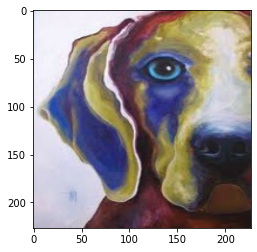

In [ ]:
plt.imshow(cv2.imread(ROOT.format("train/dog/pic_001.jpg"), cv2.IMREAD_COLOR))

# train 데이터 생성

In [ ]:
def load_datasets(img_dir):
  x_train = []
  y_train = []
  
  x_test = []
  y_test = []
  for x in classes:
    img_cate_path = "{}/{}".format(img_dir, x)
    target_dirs = os.listdir(img_cate_path)
    x_test_size = int(len(target_dirs) / 3)
    x_train_size = len(target_dirs) - x_test_size
    
    # x_train_size = 3
    for j in target_dirs[:x_train_size]:
      x_train.append(img_to_array(load_img("{}/{}".format(img_cate_path, j))))
      y_train.append([key_map[x]])
    
    for j in target_dirs[x_train_size:]:
      x_test.append(img_to_array(load_img("{}/{}".format(img_cate_path, j))))
      y_test.append([key_map[x]])

  return (np.array(x_train), np.array(y_train)), (np.array(x_test), np.array(y_test))

In [ ]:
(x_train, y_train), (x_test, y_test) = load_datasets(train_dir)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
# test_gen = test_gen.flow_from_directory(train_dir,
#                                         target_size=(227, 227),
#                                         class_mode='sparse',
#                                         batch_size=32)

In [ ]:
test_gen

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1135, 227, 227, 3), (1135, 1), (563, 227, 227, 3), (563, 1))

In [ ]:
# pd.DataFrame(data={'x': [np.array(x_test)], 'y': [np.array(y_test)]})

In [ ]:
train_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=90,
    width_shift_range=0.5,
    height_shift_range=0.5,
    brightness_range=None,
    shear_range=0.3,
    zoom_range=0.4,
    channel_shift_range=0.3,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2,
    dtype=None
)
# train_gen = data_gen.flow_from_directory(train_dir,
#                                         target_size=(227, 227),
#                                         batch_size=32,
#                                         class_mode='sparse')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
def normalize_data(x, y):
  def change_format(img, label):
    img = tf.cast(img, tf.float32)
    img = img / 255.
    return img, label

  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  return dataset.map(change_format)

In [ ]:
train_dataset = normalize_data(x_train, y_train).shuffle(len(x_train))
test_dataset = normalize_data(x_test, y_test).shuffle(len(x_test))



# load model

In [ ]:
def load_model(backbone_model):
  result = backbone_model(include_top=False, weights='imagenet', input_shape=(227, 227, 3))
  result.trainable = False
  return result

In [ ]:
backbone_vgg16 = load_model(tf.keras.applications.VGG16)
backbone_vgg19 = load_model(applications.VGG19)

# build model

In [ ]:
def plot_graphs(history, string):  # 그래프로 만들 함수
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

def check_model(backbone, name):
  model = models.Sequential(name=name)
  model.add(backbone)
  model.add(layers.Flatten())
  model.add(layers.Dense(4096))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('swish'))
  model.add(layers.Dense(4096))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('swish'))
  model.add(layers.Dense(len(classes), activation=activations.softmax))
  print(model.summary())

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'mse'])
  
  # history = model.fit(train_gen.flow(x_train, 
  #                                    y_train, 
  #                                    batch_size=32, 
  #                                    save_format='jpeg', 
  #                                    subset='training'), 
  #                     validation_data=test_gen.flow(x_train, 
  #                                                   y_train, 
  #                                                   batch_size=8,
  #                                                  save_format='jpeg', 
  #                                                   subset='validation'),
  #                     steps_per_epoch=len(x_train) / 32,
  #                     epochs=10,
  #                     batch_size=64,
  #                     verbose=False,
  #                     )
  
  history = model.fit(train_dataset.batch(64), 
                      epochs=10,
                      verbose=False,
                      validation_data=test_dataset.batch(64))

  plot_graphs(history, 'accuracy')  
  plot_graphs(history, 'loss')  

  return model



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_18 (Batc (None, 4096)              16384     
_________________________________________________________________
activation_18 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_19 (Batc (None, 4096)              16384 

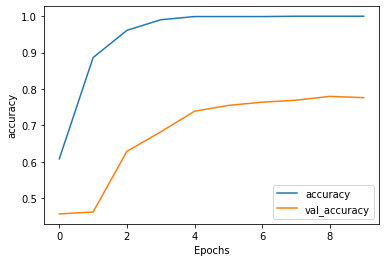

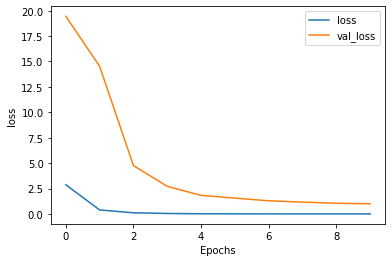

In [ ]:
model_vgg16 = check_model(backbone_vgg16, 'vgg16')

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_20 (Batc (None, 4096)              16384     
_________________________________________________________________
activation_20 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_21 (Batc (None, 4096)              16384 

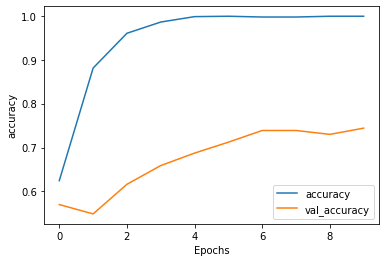

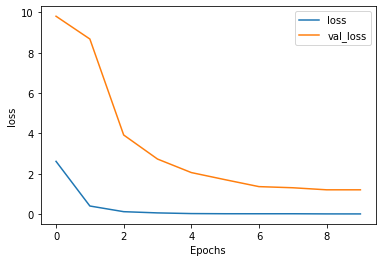

In [ ]:
model_vgg19 = check_model(backbone_vgg16, 'vgg19')

In [ ]:
def load_test_data():
  TEST_ROOT = '/content/drive/Shareddrives/머신러닝/프로그래머스/data/test/0'
  test_dirs = os.listdir(TEST_ROOT)
  
  def to_array(ROOT_PATH, x):
    img = img_to_array(load_img(f'{ROOT_PATH}/{x}'))
    return img / 255.
      
  pred_img_list = []
  for x in test_dirs:
    plt.figure()
    plt.imshow(load_img(f'{TEST_ROOT}/{x}'))
    pred_img_list.append(to_array(TEST_ROOT, x))

  return pred_img_list

submit_data = load_test_data()
len(submit_data)

In [ ]:
load_test_data()

In [ ]:
def model_predict(m, pred_img_list):
  data = [{'answer value': np.argmax(x)} for x in m.predict(np.array(pred_img_list))]
  result = pd.DataFrame(data=data, columns=['answer value'])
  result.to_csv(f"submit_{m.name}.csv")
  return result

In [ ]:
res = model_predict(model_vgg16, submit_data)
res2 = model_predict(model_vgg19, submit_data)

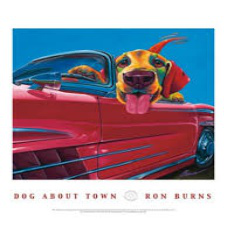

In [ ]:
res.iloc[2,]
array_to_img(submit_data[2])